# Credit Cards Defaults - Project Summary

## Why am I conducting this project?

Using the dataset on credit card default with a variety of variables relating to the demographics of the individuals and their payment history between April 2005 - September 2005, the task is to predict whether an individual defaults in the following month.

This is important for a credit card company to understand the risk level of different customers and whether there is a high risk customer type that the company could conduct further screening for before offering their services.

## Hypotheses & Metric choices

The following list will present hypotheses which I believe will have an impact on credit card default and hence why I will be adding them to the model (INITIAL ASSUMPTIONS WITH NO RELATION TO RESULTS)
 - Individuals who are more educated are likely to have better paying jobs/understand the long term implications of default and are hence less likely to default
 - Older individuals (maybe more financially mature) are less likely to default than younger individuals
 - Individuals with a higher balance limit are more likely to default (more scope for financial recklessness) - Quite weak hypothesis
 - Single individuals are more likely to default than married individuals (reduced income security)
 - Individuals who pay duly each month are less likely to default than those who do not
 - Default rate between men and women is equal
 
## Model Scores

- Evaluation metric choice: ROC_AUC score - explained <a href = '#roc_auc'> here </a>
- **Baseline model: Logisitic regression - Model cross validated score = [0.58632406 0.631525   0.62611891]**
- First iteration - Random forest classifier - Model cross validated score = [0.5677343 , 0.56818185, 0.56545654]
- First iteration - Random forest classifier (with model hypertuning) - Model cross validated score = [0.5989066 , 0.62402006, 0.62082581]
- **Second iteration - Random forest classifier (with addition payment delay variables) - Model cross validated score = [0.71882929, 0.75468678, 0.75359391]**

## Results - Business intuition

- The purpose of this project was to not only create a model which can predict default likelihood of a customer, it was also to understand the demographics and risk factors for individuals that are high risk.
- As shown by the feature importance bar chart, the top 3 most importance factors that influence whether the individual is likely to default in the next month (from the given variables), is whether they delayed payment in September by over 2+ months, whether they delayed payment in August by over 2+ months and whether they delayed payment in July by over 2+ months - This seems rather intuitive
- Individuals with higher credit balances are less likely to default
- Although age, marriage, education and sex all have lower feature importance, they are all still significant in the logistic regression (5% level of significance). 
    - There is a negative association between age and default
    - There is a positive association between marriage and default
    - There is a negative association between education and default
    - There is a positive association between being male and default
    

## Note: Further feature engineering will still be conducted to improve this project and model performance in the future.

## Exploratory Data Analysis & Cleaning the dataframe

In [63]:
#importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
from sklearn import metrics
import statsmodels.api as sm

from sklearn.ensemble import RandomForestClassifier

import warnings

In [64]:
#importing the data
creditcarddf = pd.read_csv("Dataset 5.csv")

#Basic dataframe understanding
creditcarddf.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [65]:
creditcarddf.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


By looking at value counts, I am able to understand if there are any anomalies with the data, and how I should feature engineer the variables.

<a id = 'defaultdistribution'></a>

[Text(0, 0, '0'), Text(0, 0, '1')]

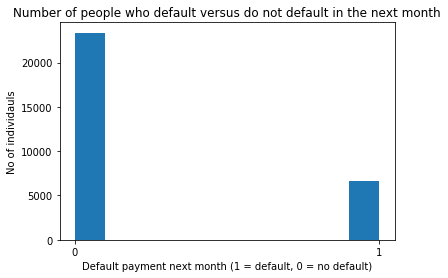

In [66]:
fig, ax = plt.subplots()
ax.hist(creditcarddf['default payment next month'])
ax.set_xlabel('Default payment next month (1 = default, 0 = no default)')
ax.set_ylabel('No of individauls')
ax.set_title('Number of people who default versus do not default in the next month')
ax.set_xticks([0,1])
ax.set_xticklabels([0,1])


In [67]:
creditcarddf['SEX'].value_counts()

2    18112
1    11888
Name: SEX, dtype: int64

In [68]:
creditcarddf['EDUCATION'].value_counts()
#(1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

In [69]:
creditcarddf['MARRIAGE'].value_counts()
#1 = Married, 2 = Single 3 = Other

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

Cleaning the dataframe

In [70]:
#Cleaning the dataframe

to_drop = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
creditcarddf = creditcarddf.drop(to_drop, axis = 1) 

creditcarddf = creditcarddf.set_index('ID') #Setting the index of the dataframe to ID

#sex column
creditcarddf['SEX_DUMMY'] = np.where(creditcarddf['SEX'] == 2, 0, 1) #Female = 0, Male = 1

#marriage column
creditcarddf['MARRIAGE_DUMMY'] = np.where(creditcarddf['MARRIAGE'] == 1, 1, 0) #Married = 1, Single/Other = 0

#education column
creditcarddf['EDUCATION_DUMMY'] = np.where(creditcarddf['EDUCATION'] <=2, 1, 0) #University grad vs non-university grad

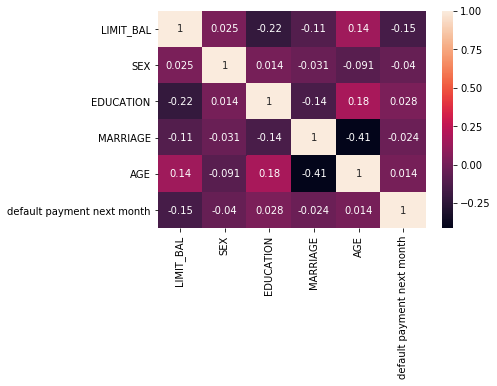

In [71]:
correlationdf = creditcarddf[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'default payment next month']]
corrMatrix = correlationdf.corr()
sn.heatmap(corrMatrix, annot = True)

The correlation matrix has a few initial insights
 - The balance limit has the strongest negative correlation with whether the individual defaults next month. This is rather intuitive as the bank are likely to lend less to individuals they pose as higher risk
 - Male individuals have a slightly higher correlation with defaulting
 - Education has a slightly lower correlation with defaulting
 - Marriage has a slightly positive correlation with defaulting
 - Age and defaulting are also weakly positively correlated
 
 The most highly correlated independent variables are: (This is important due to multicollinearity in a linear regression)
 - Age and education
 - Age and marriage

Text(0, 0.5, 'Number of individuals')

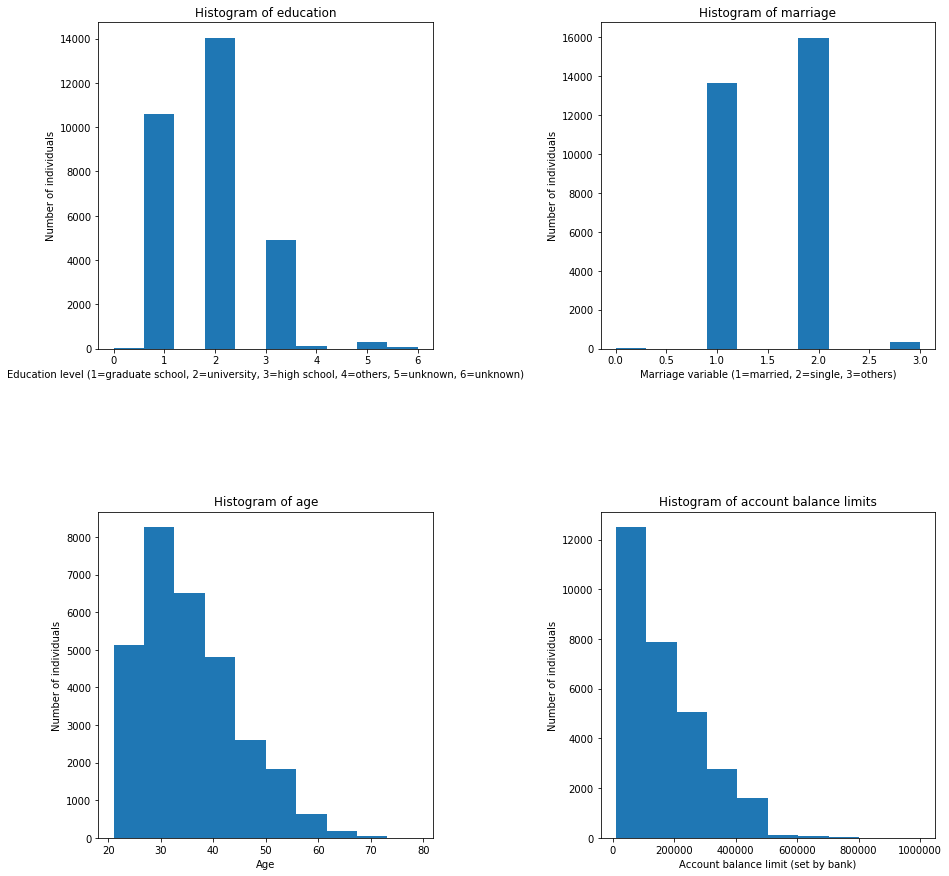

In [72]:
fig, ax = plt.subplots(2,2)
fig.subplots_adjust(wspace = 0.5, hspace = 0.5)
fig.set_size_inches(15,15)

ax[0,0].hist(creditcarddf['EDUCATION'])
ax[0,0].set_title('Histogram of education')
ax[0,0].set_xlabel('Education level (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)')
ax[0,0].set_ylabel('Number of individuals')

ax[0,1].hist(creditcarddf['MARRIAGE'])
ax[0,1].set_title('Histogram of marriage')
ax[0,1].set_xlabel('Marriage variable (1=married, 2=single, 3=others)')
ax[0,1].set_ylabel('Number of individuals')

ax[1,0].hist(creditcarddf['AGE'])
ax[1,0].set_title('Histogram of age')
ax[1,0].set_xlabel('Age')
ax[1,0].set_ylabel('Number of individuals')

ax[1,1].hist(creditcarddf['LIMIT_BAL'])
ax[1,1].set_title('Histogram of account balance limits')
ax[1,1].set_xlabel('Account balance limit (set by bank)')
ax[1,1].set_ylabel('Number of individuals')

<a id = 'roc_auc'></a>

## Baseline Logistic Regression & Evaluation Metric Determination

I have chosen to use the logisitic regression model as my baseline because it is simple and easy to understand model which (when used with the statsmodels package) can provide the marginal impact of each feature on the outcome variable.

My evaluation metric of choice is the ROC AUC score. As can be seen in the histogram of defaults <a href = '#defaultdistribution'> here </a>, the vast majority of the 30,000 individuals do not default - due to this imbalance, accuracy score would be a poor metric of choice (you could get a high accuracy score by classifying all individuals as 'no defaulters').

In [87]:
features = ['LIMIT_BAL', 'SEX_DUMMY', 'EDUCATION_DUMMY', 'MARRIAGE_DUMMY', 'AGE']
ccdefaultfeatures = creditcarddf[features]

ccdefaultlabel = creditcarddf['default payment next month']

#instantiate the model
logregmodel = LogisticRegression(solver='lbfgs')

#fit the model with data
logregmodel.fit(ccdefaultfeatures, ccdefaultlabel)

scores = cross_val_score(logregmodel, ccdefaultfeatures, ccdefaultlabel, cv=3,  scoring ='roc_auc')
print("The ROC_AUC cross validation scores are:", scores)


The ROC_AUC cross validation scores are: [0.58632406 0.631525   0.62611891]


In [74]:
#Conducting the logistic model using the statsmodels.api library
logit = sm.Logit(ccdefaultlabel, ccdefaultfeatures)
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.517905
         Iterations 6
                               Logit Regression Results                               
Dep. Variable:     default payment next month   No. Observations:                30000
Model:                                  Logit   Df Residuals:                    29995
Method:                                   MLE   Df Model:                            4
Date:                        Fri, 03 Jan 2020   Pseudo R-squ.:                 0.01990
Time:                                17:12:51   Log-Likelihood:                -15537.
converged:                               True   LL-Null:                       -15853.
Covariance Type:                    nonrobust   LLR p-value:                2.976e-135
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
LIMIT_BAL       -3.614e-06   1.31e

## Random Forest Classifier

In [89]:
def randomforestclassifier(trees, split, leaf, depth):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        rfmodel = RandomForestClassifier(n_estimators = trees, min_samples_split = split, min_samples_leaf = leaf, max_depth = depth, random_state = 42)
        rfmodel.fit(ccdefaultfeatures, ccdefaultlabel)

        rfscores = cross_val_score(rfmodel, ccdefaultfeatures, ccdefaultlabel, cv=3, scoring = 'roc_auc')
    
    return "The cross validation scores are:", rfscores

In [90]:
randomforestclassifier(100, 2, 1, None) #running model with default values

('The cross validation scores are:',
 array([0.5677343 , 0.56818185, 0.56545654]))

The cross validated scores are lower than the logistic baseline and hence there are two paths
- Hyperparameter tuning
- Feature engineering from the variety of other columns in the database (most likely to improve model power)

I will begin by seeing the impact of hyperparameter tuning.

In [28]:
#Random hyperparameter grid

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

#creating the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


In [39]:
rf = RandomForestClassifier() #base model to tune

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, random_state=42, verbose = 2, scoring = 'roc_auc')
# Fit the random search model
rf_random.fit(ccdefaultfeatures, ccdefaultlabel)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_depth=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_depth=100, total=   1.0s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_depth=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_depth=100, total=   1.0s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_depth=100 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_depth=100, total=   1.0s
[CV] n_estimators=500, min_samples_split=10, min_samples_leaf=2, max_depth=None 
[CV]  n_estimators=500, min_samples_split=10, min_samples_leaf=2, max_depth=None, total=   4.8s
[CV] n_estimators=500, min_samples_split=10, min_samples_leaf=2, max_depth=None 
[CV]  n_estimators=500, min_samples_split=10, min_samples_leaf=2, max_depth=None, total=   4.7s
[CV] n_estimators=500, min_samples_split=10, min_samples_leaf=2, max_depth=None 
[CV]  n_estimators=500, min_samples_split=10, min_samples_leaf=2, max_depth=None, total=   4.8s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_depth=20 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_depth=20, total=   2.1s
[CV] n_estimators=200, min_s

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.9min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [41]:
print(rf_random.best_params_) #finding the best parameters from the grid search

{'n_estimators': 800, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 10}


In [55]:
randomforestclassifier(800,10,4,10)

('The cross validation scores are:',
 array([0.5989066 , 0.62402006, 0.62082581]))

As we can see, the results after hypertuning 4 key parameters are slightly better but still no better than the baseline model. The next step is to engineer better features into the model.

## Further data exploration of other variables and feature engineering

Text(0, 0.5, 'Number of individuals')

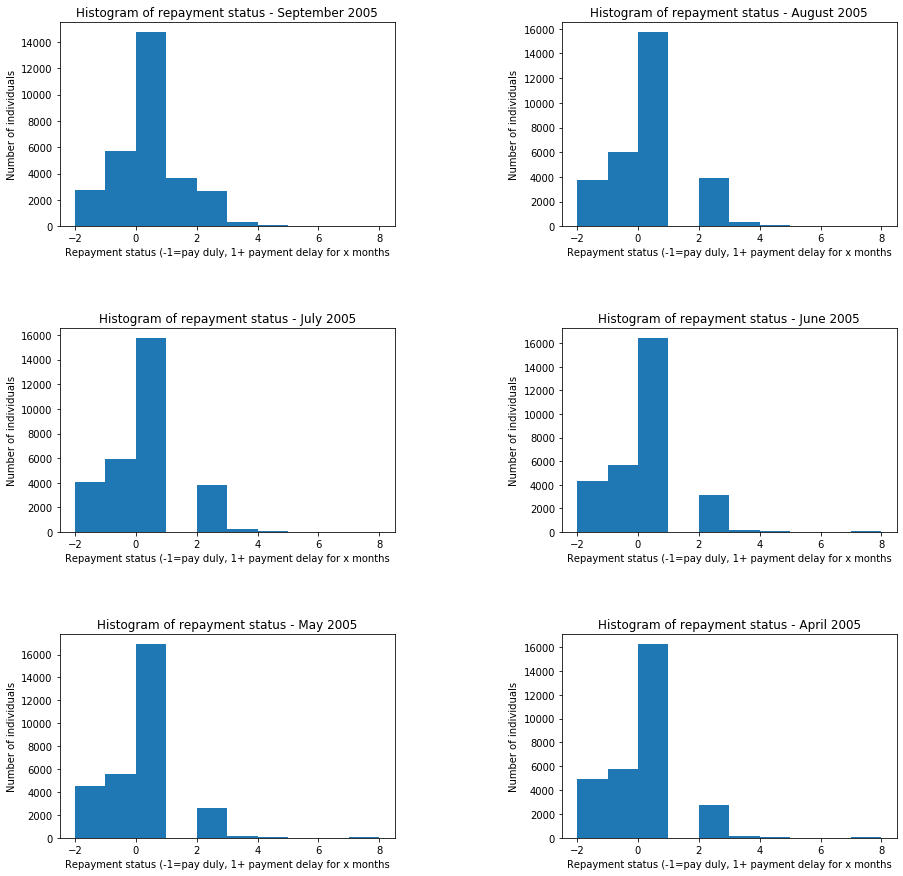

In [59]:
fig, ax = plt.subplots(3,2)
fig.subplots_adjust(wspace = 0.5, hspace = 0.5)
fig.set_size_inches(15,15)

ax[0,0].hist(creditcarddf['PAY_0'])
ax[0,0].set_title('Histogram of repayment status - September 2005')
ax[0,0].set_xlabel('Repayment status (-1=pay duly, 1+ payment delay for x months')
ax[0,0].set_ylabel('Number of individuals')

ax[0,1].hist(creditcarddf['PAY_2'])
ax[0,1].set_title('Histogram of repayment status - August 2005')
ax[0,1].set_xlabel('Repayment status (-1=pay duly, 1+ payment delay for x months')
ax[0,1].set_ylabel('Number of individuals')

ax[1,0].hist(creditcarddf['PAY_3'])
ax[1,0].set_title('Histogram of repayment status - July 2005')
ax[1,0].set_xlabel('Repayment status (-1=pay duly, 1+ payment delay for x months')
ax[1,0].set_ylabel('Number of individuals')

ax[1,1].hist(creditcarddf['PAY_4'])
ax[1,1].set_title('Histogram of repayment status - June 2005')
ax[1,1].set_xlabel('Repayment status (-1=pay duly, 1+ payment delay for x months')
ax[1,1].set_ylabel('Number of individuals')

ax[2,0].hist(creditcarddf['PAY_5'])
ax[2,0].set_title('Histogram of repayment status - May 2005')
ax[2,0].set_xlabel('Repayment status (-1=pay duly, 1+ payment delay for x months')
ax[2,0].set_ylabel('Number of individuals')

ax[2,1].hist(creditcarddf['PAY_6'])
ax[2,1].set_title('Histogram of repayment status - April 2005')
ax[2,1].set_xlabel('Repayment status (-1=pay duly, 1+ payment delay for x months')
ax[2,1].set_ylabel('Number of individuals')


This initial exploratory analysis of the repayment status variables indicate that the modal value for repayment in all months is 1 month delay. In all mnonths except September, there also seems to be a two-peaked bimodal distribution with the majority of individuals either paying on time or having a 1 month delay, none having a 2 month delay and then a subsection of the population having payment delays greater than 2 months. Hence I will use this to create a dummy variable = 1 if PAY_0 >=2 and = 0 if PAY_0 <=1. Once limitation of this data is that there is significant proportion of individuals in the '-2' category which isn't accounted for in the data description so I don't know what this value means. As the majority of individuals do not default, I'm going to treat this in the group of individuals where PAY_0 <= 2 (pay on time or short delay). 

In [78]:
creditcarddf.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,default payment next month,SEX_DUMMY,MARRIAGE_DUMMY,EDUCATION_DUMMY
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,3913,3102,689,0,0,0,1,0,1,1
2,120000,2,2,2,26,-1,2,0,0,0,...,2682,1725,2682,3272,3455,3261,1,0,0,1
3,90000,2,2,2,34,0,0,0,0,0,...,29239,14027,13559,14331,14948,15549,0,0,0,1
4,50000,2,2,1,37,0,0,0,0,0,...,46990,48233,49291,28314,28959,29547,0,0,1,1
5,50000,1,2,1,57,-1,0,-1,0,0,...,8617,5670,35835,20940,19146,19131,0,1,1,1


In [79]:
creditcarddf['PAY_0_DUMMY'] = np.where(creditcarddf['PAY_0'] >= 2, 1, 0)
creditcarddf['PAY_2_DUMMY'] = np.where(creditcarddf['PAY_2'] >= 2, 1, 0)
creditcarddf['PAY_3_DUMMY'] = np.where(creditcarddf['PAY_3'] >= 2, 1, 0)
creditcarddf['PAY_4_DUMMY'] = np.where(creditcarddf['PAY_4'] >= 2, 1, 0)
creditcarddf['PAY_5_DUMMY'] = np.where(creditcarddf['PAY_5'] >= 2, 1, 0)
creditcarddf['PAY_6_DUMMY'] = np.where(creditcarddf['PAY_6'] >= 2, 1, 0)

In [93]:
features = ['LIMIT_BAL', 'SEX_DUMMY', 'EDUCATION_DUMMY', 'MARRIAGE_DUMMY', 'AGE', 'PAY_0_DUMMY', 'PAY_2_DUMMY', 'PAY_3_DUMMY', 'PAY_4_DUMMY', 'PAY_5_DUMMY', 'PAY_6_DUMMY']
ccdefaultfeatures = creditcarddf[features]
randomforestclassifier(800,10,4,10)

('The cross validation scores are:',
 array([0.71882929, 0.75468678, 0.75359391]))

In [104]:
rfmodel = RandomForestClassifier(n_estimators = 800, min_samples_split = 10, min_samples_leaf = 4, max_depth = 10, random_state = 42)
rfmodel.fit(ccdefaultfeatures, ccdefaultlabel)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

           Variable  Feature importance
5       PAY_0_DUMMY            0.365342
6       PAY_2_DUMMY            0.171859
7       PAY_3_DUMMY            0.092684
0         LIMIT_BAL            0.090547
4               AGE            0.078845
8       PAY_4_DUMMY            0.068344
9       PAY_5_DUMMY            0.054464
10      PAY_6_DUMMY            0.040377
1         SEX_DUMMY            0.013529
3    MARRIAGE_DUMMY            0.013188
2   EDUCATION_DUMMY            0.010821


Text(0, 0.5, 'Feature importance')

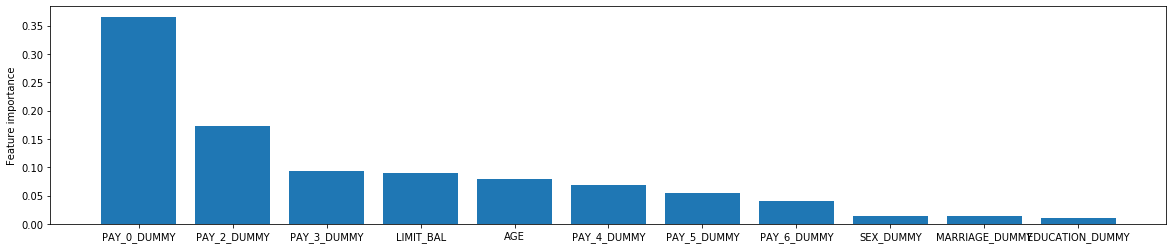

In [142]:
feature_importances = pd.DataFrame(rfmodel.feature_importances_, index = ccdefaultfeatures.columns)
feature_importances.reset_index(inplace = True)
feature_importances.columns = ['Variable','Feature importance']
feature_importances = feature_importances.sort_values(by = 'Feature importance', ascending = False)
print(feature_importances)

fig, ax = plt.subplots()
fig.subplots_adjust(wspace = 0.5, hspace = 0.5)
fig.set_size_inches(20,4)
ax.bar(feature_importances['Variable'], feature_importances['Feature importance'])
ax.set_ylabel('Feature importance')
